<a href="https://colab.research.google.com/github/satoru2001/Handwritten_DigitRecognition/blob/master/HandDigit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Kaggle and Downloading Dataset

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c digit-recognizer

 98% 9.00M/9.16M [00:01<00:00, 7.49MB/s]
100% 9.16M/9.16M [00:01<00:00, 6.77MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 71.0MB/s]
 82% 5.00M/6.09M [00:00<00:00, 16.2MB/s]
100% 6.09M/6.09M [00:00<00:00, 17.5MB/s]


# Unzipping Train and Test to '/tmp'

In [ ]:
import os
import zipfile
ref = '/content/train.csv.zip'
zip_ref = zipfile.ZipFile(ref,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
ref = '/content/test.csv.zip'
zip_ref = zipfile.ZipFile(ref,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Loading Train Data

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/tmp/train.csv',index_col=None)
df.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Splitting to Labels,Images and reshaping Images to (28,28,1)

In [ ]:
labels = df['label'].to_numpy()
labels[:10]

array([4, 8, 7, 4, 1, 1, 5, 1, 3, 5])

In [ ]:
image_df = df.drop(axis=1,columns = 'label')
images = image_df.to_numpy()

In [ ]:
images = images.reshape(42000,28,28)

In [ ]:
images.shape

(42000, 28, 28)

In [ ]:
import numpy as np
images = np.expand_dims(images,axis=-1)
images = images/255

In [ ]:
images[1].shape

(28, 28, 1)

# Test Train Split and Model

In [ ]:
import tensorflow
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,BatchNormalization,Dropout,Lambda,Flatten
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
clear_session() 
opt = Adam(lr=0.0005)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(images,labels,test_size=0.1)

In [ ]:
CNN = Sequential()

#Convolution layer 1
CNN.add(Conv2D(8,(3,3),activation='relu',input_shape=(28,28,1),kernel_regularizer='l2'))
CNN.add(MaxPooling2D())
CNN.add(BatchNormalization())
CNN.add(Dropout(0.2))

#Convolution layer 2
CNN.add(Conv2D(32,(3,3),activation='relu',kernel_regularizer='l2'))
CNN.add(MaxPooling2D())
CNN.add(BatchNormalization())
CNN.add(Dropout(0.2))

#Convolution layer 3
CNN.add(Conv2D(64,(3,3),activation='relu',kernel_regularizer='l2'))
CNN.add(MaxPooling2D())
CNN.add(BatchNormalization())
CNN.add(Dropout(0.2))

# Flatten Layer
CNN.add(Flatten())

# Dense Layer 1
CNN.add(Dense(1024,activation='relu',kernel_regularizer='l2'))
CNN.add(Dropout(0.15))

#Dense Layer 2
CNN.add(Dense(128,activation='relu',kernel_regularizer='l2'))
CNN.add(Dropout(0.15))

#Output
CNN.add(Dense(10,activation='softmax',kernel_regularizer='l2'))

CNN.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'],)

CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 8)         32        
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        2336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 32)          1

# Call Backs for
- To stop training when an accuracy of 99% Reached
- To decrease Learning rate if previous 2 epochs val_loss is not changed
- To store maximum val_accuracy weights

In [ ]:
class myCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99999):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

stop_callback = myCallback()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001,
                              patience=3, min_lr=0.000001, mode='auto')

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

callbacks = [checkpoint, reduce_lr ,stop_callback]

# Training

In [ ]:
history = CNN.fit(x=x_train,y=y_train,batch_size=32,epochs=30,validation_data=(x_test,y_test),shuffle=True,callbacks=callbacks)

Epoch 1/30
1175/1182 [============================>.] - ETA: 0s - loss: 0.2973 - accuracy: 0.9699
Epoch 00001: saving model to model_weights.h5
1182/1182 [==============================] - 5s 4ms/step - loss: 0.2972 - accuracy: 0.9700 - val_loss: 0.2529 - val_accuracy: 0.9821 - lr: 1.0000e-06
Epoch 2/30
1180/1182 [============================>.] - ETA: 0s - loss: 0.2942 - accuracy: 0.9709
Epoch 00002: saving model to model_weights.h5
1182/1182 [==============================] - 5s 4ms/step - loss: 0.2942 - accuracy: 0.9708 - val_loss: 0.2525 - val_accuracy: 0.9829 - lr: 1.0000e-06
Epoch 3/30
1168/1182 [============================>.] - ETA: 0s - loss: 0.2920 - accuracy: 0.9712
Epoch 00003: saving model to model_weights.h5
1182/1182 [==============================] - 5s 4ms/step - loss: 0.2920 - accuracy: 0.9712 - val_loss: 0.2509 - val_accuracy: 0.9826 - lr: 1.0000e-06
Epoch 4/30
1180/1182 [============================>.] - ETA: 0s - loss: 0.2940 - accuracy: 0.9702
Epoch 00004: saving 

# Plotting Training,Testing Accuracies

In [ ]:
import matplotlib.pyplot as plt

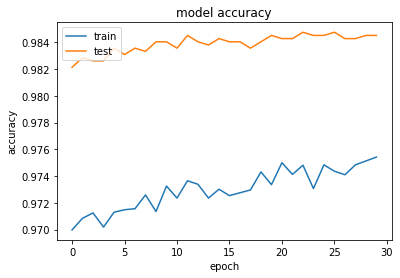

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

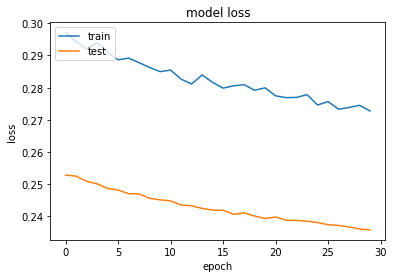

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loading Test data,Resize and predicting

In [ ]:
test_df = pd.read_csv('/tmp/test.csv')
test_images = test_df.to_numpy()
test_images = test_images.reshape(28000,28,28)
test_images = np.expand_dims(test_images,axis=-1)
test_images = test_images/255
test_images.shape

(28000, 28, 28, 1)

In [ ]:
predict_model = Model(CNN.input,CNN.output)
predict_model.load_weights('model_weights.h5')

In [ ]:
predictions = predict_model.predict(test_images)
prediction_classes = np.argmax(predictions,axis=1)

In [ ]:
prediction_classes[:10]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

In [ ]:
columns = ['ImageId','Label']

In [ ]:
ImageId = np.arange(1,28001,1)
ImageId.shape

(28000,)

In [ ]:
list_of_tuples = list(zip(ImageId.tolist(),prediction_classes.tolist()))  

In [ ]:
test_df = pd.DataFrame(list_of_tuples, columns=columns)  

In [ ]:
test_df.to_csv('test.csv',index=False)